<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC

## Access ACTRIS CLU data

In [1]:
from pathlib import Path
import datetime

import requests
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import IntProgress
from IPython.display import display

### Download

We're going to use Cloudnet data portal API to search and download netCDF4 files. For more information, see <https://docs.cloudnet.fmi.fi>.

Let's download all classification products from Hyytiälä in 2022. These products contain Cloudnet classification of atmospheric scatterers detected by radar and lidar.

In [2]:
outdir = Path("clu-data")
outdir.mkdir(exist_ok=True)
r = requests.get("https://cloudnet.fmi.fi/api/files", 
                 params={"site": "hyytiala",
                         "product": "classification",
                         "dateFrom": "2022-01-01",
                         "dateTo": "2022-12-31"})
r.raise_for_status()
files = r.json()
progress = IntProgress(min=0, max=len(files), description="Download:")
display(progress)
for file in files:
    r = requests.get(file["downloadUrl"])
    r.raise_for_status()
    (outdir / file["filename"]).write_bytes(r.content)
    progress.value += 1

IntProgress(value=0, description='Download:', max=352)

### Analyse

Count and visualise number of pixels containing insects relative to the total number of pixels. Insect are indicated by classification class 9 (insects, no cloud or precipitation) and class 10 (aerosol coexisting with insects, no cloud or precipitation).

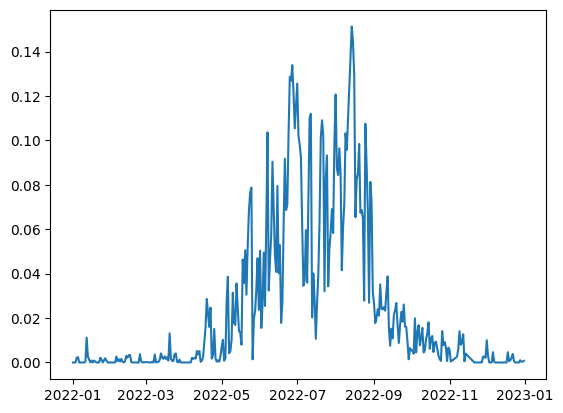

In [3]:
dates = []
insects = []
for p in sorted(outdir.iterdir()):
    with netCDF4.Dataset(p) as nc:
        n_total = np.prod(nc["target_classification"].shape)
        n_insects = np.count_nonzero(nc["target_classification"][:] == 9)
        n_aerosols_and_insects = np.count_nonzero(nc["target_classification"][:] == 10)
        dates.append(datetime.date(int(nc.year), int(nc.month), int(nc.day)))
        insects.append((n_insects + n_aerosols_and_insects) / n_total)
plt.plot(dates, insects)
plt.show()